In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from opencc import OpenCC
import jieba
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.merge import add
from keras.layers import LSTM,Bidirectional, Dropout,GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
def performance(y, y_hat):
    print("accuracy: {}".format(accuracy_score(y, y_hat,normalize=False)))
    print("precision: {}".format(precision_score(y, y_hat,average='micro')))
    print("recall: {}".format(recall_score(y, y_hat)))
    print("roc_auc: {}".format(roc_auc_score(y, y_hat)))

# 读取数据

In [3]:
data = pd.read_csv('D:/senior/aiCourse/dataSource/comment_classification/train/sentiment_analysis_trainingset.csv',encoding='UTF-8')

In [4]:
data.columns

Index(['id', 'content', 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again'],
      dtype='object')

In [5]:
#填充空白格
data['content'] = data['content'].fillna('')

In [6]:
sample = 1000
random_indices = np.random.choice(np.arange(len(data['content'])), sample)
sub_data = data.iloc[random_indices]

In [7]:
sub_data.head()

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
56654,56654,"""经常来的就是七向街的店了，除了披萨跟自助，其他基本都倒闭了。当时我怀孕都九个月了，就想吃米...",-2,-2,-2,-2,-2,-2,-2,-1,...,-2,-2,-2,1,-2,-2,-2,-2,1,-2
24578,24578,"""小学就存在的老店。家族博饼来这里开吃。订了包间。包间能容纳10几个人，有厕所，厕所挺干净的...",-2,-2,-2,-2,1,-2,1,-1,...,0,-2,1,-2,-1,0,1,0,0,-2
99323,99323,"""小店的门脸不大，但是相对还是有口碑。店不大但是很温馨。有时候不提前预定可能就没位置了。身为...",-2,-2,-2,-2,-2,-2,-2,1,...,1,1,0,-2,1,1,-2,-2,1,1
48082,48082,"""我一直在湖北武汉长大滴，自从来北京上大学以后真的是太想念家乡的美食了！尤其是香辣小龙虾！(...",-2,-2,-2,-2,-2,-2,-2,1,...,-2,-2,-2,1,-2,1,-2,-2,1,-2
91894,91894,"""第一次来吃的时候很好吃，点的所有菜都很好吃，菜也感觉很新鲜。这次特地带了朋友过来吃，结果，...",-2,-2,-2,-2,1,-2,-2,-2,...,-2,-2,-2,-2,0,0,-2,-2,0,-2


# 预处理，主要处理content字段

In [8]:

def is_CN_char(ch):
    return ch >= u'\u4e00' and ch <= u'\u9fa5'

def cut(string):
    return list(jieba.cut(string))

def get_stopwords(filename = "D:/senior/aiCourse/dataSource/stop_word.txt"):
    stopwords_dic = open(filename, encoding= 'utf-8')
    stopwords = stopwords_dic.readlines()
    stopwords = [w.strip() for w in stopwords]
    stopwords_dic.close()
    return stopwords

def convert2simple(word):
    openCC = OpenCC('tw2sp')
    return openCC.convert(word)

In [9]:
stopwords = get_stopwords()

In [10]:
def clean_sentence(sentence):
    stopwords = get_stopwords()
    sentence = ''.join(filter(is_CN_char,sentence))
    #print(sentence)
    
    
    sentence = convert2simple(sentence)
    words = [w for w in cut(sentence) if len(w)>0 and w not in stopwords]
    #print(words)
    words = ' '.join(words)
    return words  

In [11]:
clean_sentence("哈哈哈哈哈")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Andywong\AppData\Local\Temp\jieba.cache
Loading model cost 0.784 seconds.
Prefix dict has been built succesfully.


'哈哈哈 哈哈'

In [12]:
sub_data['content'] = sub_data['content'].apply(clean_sentence)

e:\anaconda\envs\aicourse\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
sub_data['content'][:10]

56654    七向 街 除了 披萨 自助 其他 基本 倒闭 当时 怀孕 九个 月 米 斯特 老公 带 餐厅...
24578    小学 存在 老店 家族 博饼 开吃订 包间 包间 容纳 几个 人有 厕所 厕所 挺 干净 休...
99323    小店 门脸 不 大 但是 口碑 店不大 但是 温馨 有时候 不 提前 预定 没 位置 身为 ...
48082    在 湖北 武汉 长大 滴 北京 大学 以后 真的 想念 家乡 美食 尤其 香辣 小龙虾 学校...
91894    第一次 好吃 菜 好吃 菜 新鲜 这次 特 地带 朋友 失望 黄 咖喱鸡 那个 鸡肉 好 老...
23768    店铺 小小的 一家 风格 但是 干净 公司 近 试一试 试营业 期间 没 时间 已经 正式 ...
99758    春江 饭店 济南 老字号 饭店 前些天 聚 丰德 城南 往事 这会 惦记 春江 饭店 春江 ...
38253    在 久 搜 大众 点评 周围 美食 发现 自助 真的 超 便宜 网评 算 不错 大家 评价 ...
96026    大 实话 很棒 评价 不错 不过 在 巨时 没 但是 几次 在 巨时 消费 感受 太差 决定...
3903     本来 晃 万达 准备 回家 听到 楼上 服务员 妹纸 吆喝 临时 决定 上楼 吃个 烤鱼 回...
Name: content, dtype: object

In [14]:
def word_to_id(vocab):
    counts = Counter(vocab)
    #print(counts)
    vocab = sorted(counts, key=counts.get, reverse=True)
    word_to_id = { word : i for i, word in enumerate(vocab)}
    id_to_word = {i:word for i,word in enumerate(vocab)}
    return word_to_id, id_to_word

In [15]:
vocab = ' '.join(sub_data['content']).split()
vocab.append('unknown')
word_to_id, id_to_word = word_to_id(vocab)

In [16]:
type(vocab)

list

In [17]:
def comment_to_id(word_to_id,comments):
    comment_to_id = []
    for comment in comments:
        comment_to_id.append([word_to_id[word] for word in comment.split()] )
    return comment_to_id

In [18]:
comment_to_id = comment_to_id(word_to_id,sub_data['content'])

In [19]:
def pad_sequences(comment_to_id,maxlen,padding,truncating):
    features = np.zeros((len(comment_to_id), maxlen), dtype=int)
    for i,comment in enumerate(comment_to_id):
        if len(comment) <= maxlen and padding == 'pre':
            features[i, -len(comment):] = np.array(comment)[:maxlen]
        if len(comment) <= maxlen and padding == 'post':
            features[i, :len(comment)] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'post':
            features[i, :] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'pre':
            features[i, :] = np.array(comment)[len(comment)-maxlen:]           
    return features

In [20]:
pad_comments = pad_sequences(comment_to_id,maxlen=200,padding='post',truncating='post')

In [21]:
pad_comments.shape

(1000, 200)

In [22]:
data.columns

Index(['id', 'content', 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again'],
      dtype='object')

In [23]:
labels = sub_data[[ 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again']].values

In [24]:
def dig_lists(l):
    output = []
    for e in l:
        if isinstance(e, list):
            output += dig_lists(e)
        else:
            output.append(e)
    return(output)

In [25]:
answer ={-2:[1,0,0,0],-1:[0,1,0,0],0:[0,0,1,0],1:[0,0,0,1]}


y_test = []
for line in labels:
    lineTemp = []
    for item in line:        
        lineTemp.append(answer[item])   
                       
    l2=dig_lists(lineTemp)
    y_test.append(l2)

In [26]:
for i in range(len(labels)):
    for j in range(20):
        labels[i][j]+=2

In [27]:
len(y_test[5])

80

In [28]:
def convert_2_labels(answer):
    labels_input = []
    for item in answer:
        answer_temp = []
        for i in range(0,80,4):
            answer_temp.append(np.argmax(item[i:i+4]))
        labels_input.append(answer_temp)
    return labels_input



In [29]:
def split_dataset(pad_comments,labels,split_frac):
    split_index = int(len(pad_comments)*split_frac)
    data_list = list(zip(pad_comments, labels))
    random.shuffle(data_list)
    pad_comments, labels = zip(*data_list)
    x_train, x_test = pad_comments[:split_index], pad_comments[split_index:]
    y_train, y_test = labels[:split_index], labels[split_index:]
    return x_train,y_train,x_test,y_test 

In [30]:
temp_answer = convert_2_labels(y_test)

In [31]:
temp_answer[8]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3]

In [32]:
 labels[8]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3],
      dtype=int64)

In [33]:
for i in range(0,19):
    if temp_answer[0][i] == labels[0][i]:
        print('same')

same
same
same
same
same
same
same
same
same
same
same
same
same
same
same
same
same
same
same


In [34]:
import random
x_train,y_train,x_test,y_test = split_dataset(pad_comments,y_test,0.8)

In [52]:
len(x_train[0])

200

# Model

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.merge import add
from keras.layers import LSTM,Bidirectional, Dropout,GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import regularizers

In [36]:
max_comment_length = 200
embedding_vecor_length = 300

In [37]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test) 

In [38]:
"""Baseline model"""
def get_model():
    embed_size = 128
    inp = Input(shape=(200, ))
    x = Embedding(90000, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [39]:
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
def get_model():
    embed_size=128
    sequence_input = Input(shape=(200, ))
    x = Embedding(90000, embed_size, trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.2))(x)
    x = Conv1D(32, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool]) 
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    preds = Dense(80, activation="sigmoid")(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
    return model

In [40]:
model = get_model()

In [41]:
print(model.summary())
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=5,verbose=1, batch_size=40)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 128)     11520000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 128)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 256)     197376      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

model = Sequential()
model.add(Embedding(len(word_to_id), embedding_vecor_length, input_length=max_comment_length, dropout=0.2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.5))
model.add(Dense(80, activation='sigmoid', activity_regularizer=regularizers.l2(0.001)))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=5,verbose=1, batch_size=1000)

In [42]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


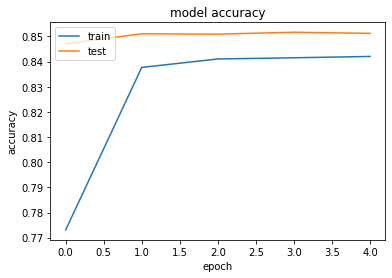

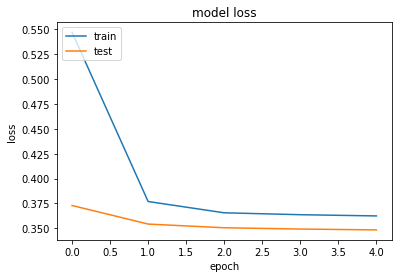

0.0


In [43]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

preds = model.predict(x_train)
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
print(accuracy(preds,y_train))

In [44]:
preds

array([[0.774679  , 0.01450918, 0.01053114, ..., 0.02916344, 0.02581992,
        0.31792173],
       [0.789705  , 0.01263186, 0.00844399, ..., 0.0245151 , 0.02352962,
        0.31405163],
       [0.79987186, 0.01169961, 0.00745545, ..., 0.02202516, 0.02204286,
        0.30596554],
       ...,
       [0.79465765, 0.01168069, 0.00767276, ..., 0.02241738, 0.02224088,
        0.31237358],
       [0.7918894 , 0.01349027, 0.0087975 , ..., 0.0248715 , 0.02386432,
        0.30599326],
       [0.8085357 , 0.01075056, 0.00658227, ..., 0.01935756, 0.02062545,
        0.30306157]], dtype=float32)

In [45]:
convert_2_labels(preds)

[[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,

In [46]:
convert_2_labels(y_test)

[[0, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0],
 [0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 2, 0, 0, 3, 0],
 [3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 3, 3, 0, 2, 0, 0, 3, 3],
 [3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 0],
 [0, 0, 2, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 3, 0, 3, 0, 0, 3, 0],
 [0, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3],
 [0, 0, 0, 0, 3, 0, 2, 1, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 3, 0],
 [0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3, 3],
 [0, 0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 0],
 [0, 0, 1, 0, 3, 0, 0, 2, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0],
 [3, 0, 3, 0, 3, 0, 0, 2, 0, 3, 3, 3, 2, 2, 2, 2, 3, 0, 3, 0],
 [0, 0, 0, 3, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 3, 0, 0, 3, 3],
 [0, 0, 1, 0, 3, 0, 0, 1, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3],
 [0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0,

In [47]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [48]:
coun=0
all1=0
for line in convert_2_labels(preds):
    for item in line:
        if item == 1:
            coun+=1
        all1+=1

In [49]:
coun/all1

0.0

In [50]:
hahahahaha

NameError: name 'hahahahaha' is not defined

In [ ]:
class DataLoader():
    def __init__(self,filename,sampleNum):
        self.filename = filename
        self.data = self.load_data()
        random_indices = np.random.choice(np.arange(len(self.data['content'])), sampleNum)
        self.sub_data = self.data.iloc[random_indices]
        self.sub_data['content'] = self.sub_data['content'].apply(self.clean_sentence)

    def load_data(self):
        return pd.read_csv(self.filename,encoding='UTF-8')

    def is_CN_char(self,ch):
        return ch >= u'\u4e00' and ch <= u'\u9fa5'

    def cut(self,string):
        return list(jieba.cut(string))

    def get_stopwords(self,filename = "D:/senior/aiCourse/dataSource/stop_word.txt"):
        stopwords_dic = open(filename, encoding= 'utf-8')
        stopwords = stopwords_dic.readlines()
        stopwords = [w.strip() for w in stopwords]
        stopwords_dic.close()
        return stopwords

    def convert2simple(self,word):
        openCC = OpenCC('tw2sp')
        return openCC.convert(word)

    def clean_sentence(self,sentence):
        stopwords = self.get_stopwords()
        sentence = ''.join(filter(self.is_CN_char,sentence))
        #sentence = convert2simple(sentence)
        words = [w for w in self.cut(sentence) if len(w)>1 and w not in stopwords]
        words = ' '.join(words)
        return words


trainData = DataLoader('D:/senior/aiCourse/dataSource/comment_classification/train/sentiment_analysis_trainingset.csv',5000)


In [ ]:
testData = DataLoader('D:/senior/aiCourse/dataSource/comment_classification/test/sentiment_analysis_testa.csv',1000)

In [ ]:
class data2vec():
    def __init__(self,inputData):

        self.vocab = ' '.join(inputData['content']).split()
        
        self.vocab.append('unknown')
        
        self.word_to_id, self.id_to_word = self.word_to_id(self.vocab)

        self.comment_to_id = self.comment_to_id(self.word_to_id,inputData['content'])

        self.pad_comments = self.pad_sequences(self.comment_to_id,maxlen=200,padding='post',truncating='post')
        
    def word_to_id(self,vocab):
        counts = Counter(vocab)
        vocab = sorted(counts, key=counts.get, reverse=True)
        word_to_id = { word : i for i, word in enumerate(vocab)}
        id_to_word = {i:word for i,word in enumerate(vocab)}
        return word_to_id, id_to_word


    def comment_to_id(self,word_to_id,comments):
        comment_to_id = []
        for comment in comments:
            comment_to_id.append([word_to_id[word] for word in comment.split()] )
        return comment_to_id


    def pad_sequences(self,comment_to_id,maxlen,padding='post',truncating='post'):
        features = np.zeros((len(comment_to_id), maxlen), dtype=int)
        for i,comment in enumerate(comment_to_id):
            if len(comment) <= maxlen and padding == 'pre':
                features[i, -len(comment):] = np.array(comment)[:maxlen]
            if len(comment) <= maxlen and padding == 'post':
                features[i, :len(comment)] = np.array(comment)[:maxlen]
            if len(comment) > maxlen and truncating == 'post':
                features[i, :] = np.array(comment)[:maxlen]
            if len(comment) > maxlen and truncating == 'pre':
                features[i, :] = np.array(comment)[len(comment)-maxlen:]
        return features

In [ ]:
trainDataId = data2vec(trainData.sub_data)
testDataId = data2vec(testData.sub_data)

In [ ]:
y_train = trainData.sub_data[[ 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again']].values

y_test =  testData.sub_data[[ 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again']].values

for i in range(len(y_test)):
    for j in range(20):
        y_test[i][j]+=2

x_train,y_train,x_test,y_test = split_dataset(pad_comments,labels,0.8)